<a href="https://colab.research.google.com/github/JTorgander/interbayes-workshop/blob/main/InterBayes-workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Stan - Workshop 

In this workshop we will investigate how Bayesian methods and Stan can be used for statistical inference and data analysis. Using the CmdStan framework, we will demonstrate how to define and import Stan models into R. We will also investigate different tools for convergence diagnostics, model evaluation and comparison. 

__Note__: This notebook is an adaptation of Andrew Johnsson's  excellent lecture in [Bayesian Workflow](https://github.com/andrjohns/ProbAI-2024) for the Nordic Probabilisitc AI summer school 2024.


## Setup

In this tutorial we will be using the [cmdstanr](https://mc-stan.org/cmdstanr/articles/cmdstanr.html) R interface to CmdStan. We first setup the environment for using Stan in R by the following code

In [80]:
# Use a repository of pre-built package binaries to speed-up installation
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")

# Install the R Packages we'll be using
install.packages(c("dplyr", "bayesplot", "cmdstanr", "loo"),
                  repos = c("https://stan-dev.r-universe.dev", getOption("repos")))

# Install and setup CmdStan
download.file("https://github.com/stan-dev/cmdstan/releases/download/v2.35.0/colab-cmdstan-2.35.0.tgz",
              "cmdstan-2.35.0.tgz")
utils::untar("cmdstan-2.35.0.tgz")
cmdstanr::set_cmdstan_path("cmdstan-2.35.0")

# Download the files for the tutorial
system("git clone https://github.com/JTorgander/interbayes-workshop")
setwd("interbayes-workshop")


The downloaded binary packages are in
	/var/folders/_p/hf4dbz795jj8k6fkpxsdnfqr0000gn/T//Rtmp5uqzXQ/downloaded_packages


## Importing libraries

In [2]:
library(cmdstanr)
library(bayesplot)
library(ggplot2)
library(dplyr)
library(loo)

This is cmdstanr version 0.8.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/jakto159/.cmdstan/cmdstan-2.34.1

- CmdStan version: 2.34.1


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable cmdstanr_no_ver_check=TRUE.

This is bayesplot version 1.11.1.9000

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


This is loo version 2.8.0.9000

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument 

## Case study introduction: Epilepsy data set


We will in this tutorial base our modeling on the "Epilepsy" data set which contains data corresponding to a randomized-controlled trial for a new epilepsy drug. The data set contains information about the following
* 59 participants divided into a treatment and control groups consisting of 31 and 28 observations respectively.
* Predictors:
    * Age of participant
    * Baseline number of seizures
    * Visit period (1-4)
* Response/outcome variable: number of seizures since last visit. Counts were recorded for four successive two-week periods. 

The data is provided in a .rds file which can be imported into R as follows,

In [29]:
epilepsy <- readRDS("epilepsy.rds")

### 1. Creating a baseline model 
As a baseline model we will use a multiple normal linear regression as our initial attempt for modeling the data:

\begin{align*}
y_i &\sim N(\alpha + x_i^T\beta, \sigma) \\
\alpha &\sim N(0, 10) \tag{1} \\
\beta &\sim N(0, 10) \\ 
\sigma &\sim N^+(0,10),
\end{align*}

where $N^+,$ denotes the truncated normal distribution. To define this model, we create a .stan file and put our model code in this file. The Stan-file is then is imported and compiled using CmdStan. An example Stan file for this model has been prepared and is located in the "models" subfolder of this repo. The contents of the file can be seen below:

In [4]:
cat(readLines("models/normal.stan"), sep = "\n")

data {
  int N;
  int T;
  int K;
  matrix[N*T, K] x;
  vector[N*T] y;
}
parameters {
  real alpha;
  vector[K] beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);
  sigma ~ normal(0, 10);
}
generated quantities {
  array[N*T] real ypred;
  ypred = normal_rng(alpha + x * beta,
                     sigma);
}


#### Data preparation
Next, to define our Stan-sampler we first need to prepare our data to a format which matches the format of our Stan-file. This means that we need to define an input list in R such that each object in the "data" block is featured in the list.

As covariates for our regression model we will here use the treatment group, treatment period, age and baseline seizures together with a treatment group/period cross term. The data is prepared as follows,

In [5]:
epilepsy_prep <- epilepsy %>%
  mutate(Trt = as.numeric(Trt) - 1,
         visit = as.numeric(visit) - 1,
         treat_x_visit = Trt * visit)

data <- list(
  N = length(unique(epilepsy_prep$patient)),
  T = length(unique(epilepsy_prep$visit)),
  K = 5,
  x = epilepsy_prep[,c("Trt", "visit", "treat_x_visit", "zAge", "zBase")],
  y = epilepsy_prep$count
)

#### Sampling

Using the prepared data we are now ready to sample from our first model. The model is first imported into R and compiled by the following code.

In [6]:
model1 <- cmdstan_model("models/normal.stan")

We can now sample from our model

In [15]:
fit1 <- model1$sample(
  data = data,
  parallel_chains = 4,
  refresh = 0,
  show_exceptions = FALSE,
  seed = 2025
)

Running MCMC with 4 parallel chains...

Chain 1 finished in 0.1 seconds.
Chain 2 finished in 0.1 seconds.
Chain 3 finished in 0.1 seconds.
Chain 4 finished in 0.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.2 seconds.



#### Convergence diagnostics

To verify that our sampler has converged properly we first inspect the corresponding traceplots. Since the number of possible plots in our case is very high, we will here restrict our attention to the samples of the regression coefficients $\beta_{1:5}$

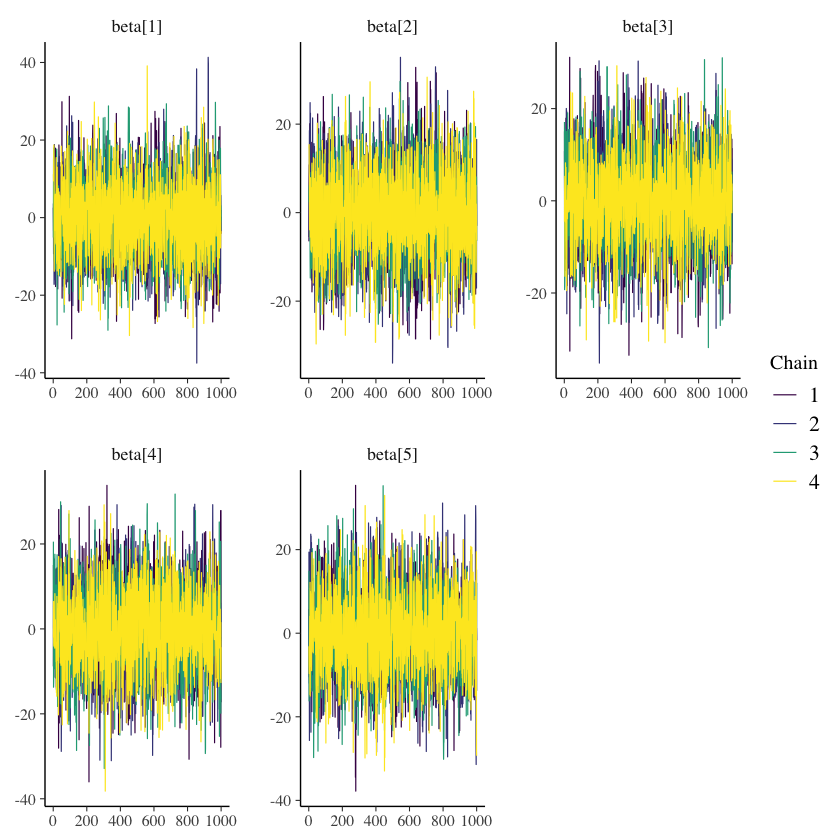

In [8]:
# Producing traceplots
color_scheme_set("viridis")
mcmc_trace(fit1$draws(), regex_pars = "beta")

We see from these plots clear signs that our model indeed has converged. Another indication that our sampler has converged properly can be found by inspecting the $\hat{R}$ and ESS-values corresponding to our sampler. These values can be directly extracted from out fitted Stan object as follows.

In [9]:
fit1$summary(c("alpha" ,"beta"))

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
alpha,0.165267861,0.2842975,10.340610,10.207556,-16.71230,16.84608,0.9998893,5461.212,2807.116
beta[1],0.047075793,0.0815020,10.101374,10.343359,-16.14734,16.74561,1.0006519,5333.774,3029.881
beta[2],-0.100555305,-0.0927401,10.102643,10.018951,-17.31560,16.39094,1.0000705,5051.194,2813.535
beta[3],-0.017231739,0.0277107,9.806851,9.416505,-16.43570,16.11949,1.0043558,5139.618,2999.237
beta[4],-0.269920518,-0.3027685,9.987968,10.067247,-16.51030,16.00114,1.0025227,5357.068,3244.383
beta[5],-0.005849642,-0.1055345,10.142563,10.452500,-16.39304,16.76550,1.0006190,4980.338,2403.147


Having verified convergence, we can proceed to conduct inference. A natural first step is to illustrate the marginal posterior distributions using a histogram:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


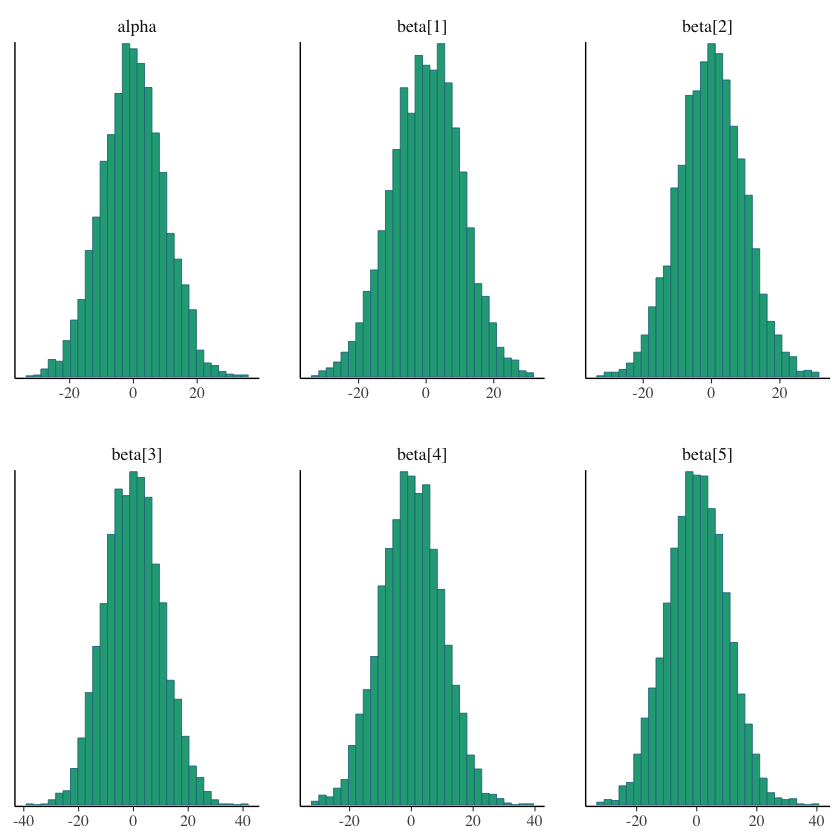

In [16]:
mcmc_hist(fit1$draws(c("alpha" ,"beta")))

Interestingly enough, we see here that all regression coefficients posterior are centered around zero, indicating an (on average) non-significant effect of our covariates on our response variable. In particular, using this model there is no clear indication of any treatment effect, corresponding to the coefficient $\beta_1$.

To investigate this further, we compute the corresponding estimated means of each marginal posterior distribution. To do this we recall the Monte Carlo approximation formula
$$\mathbb{E}[h(X)] \approx \frac{1}{N}\sum_{i=1}^N h(\theta^{(i)}), \tag{2}$$
where $\theta^{(i)}$ is our drawn samples. We see that letting $h(x) = x$, this resulting expression just corresponds to computing the sample mean over our samples. Thus, the posterior means are estimated using the sample means of our samples:

In [1]:
reg_coef_matrix <- fit1$draws(c("alpha" ,"beta"), format = "matrix") # Extracting reg. coefficient samples
sample_means <- colMeans(reg_coef_matrix)
as.data.frame(sample_means)

ERROR: Error: object 'fit1' not found


Similarly, by letting $h(x) = 1(x >0)$ be the indicator function, we can compute the empirical probability that the regression coefficients are positive:

In [12]:
coef_is_positive <- reg_coef_matrix > 0 # h(x) = 1(x > 0)
coef_is_positive_prob <- colMeans(coef_is_positive)
as.data.frame(coef_is_positive_prob)

,coef_is_positive_prob
,<dbl>
alpha,0.51150
beta[1],0.50350
beta[2],0.49650
beta[3],0.50125
beta[4],0.49125
beta[5],0.49500


Put together, we are not able to detect any significant treatment effect on the number of seizures using our baseline model. 


## Exercise 1: ##
To achieve a better understanding of the Monte Carlo integration formula (1), we are in this exercise going to compute the posterior _variance_ of the treatment effect $\beta_1$ parameter only using samples from Stan together with the standard formula
\begin{equation}
\operatorname{Var}(X) = \mathbb{E}[X^2] - \mathbb{E}[X]^2 \tag{3}
\end{equation}
using the following procedure
1. Modify the $\verb|generated quantities|$ block to return __squared__  (second moment) samples, i.e. let $h(\beta_1) = \beta_1^2$ 
2. Compute the variance using the formula (3) together with the Monte Carlo approximation (2)
3. Compare the result with using R's $\verb|var|$-function directly on the $\beta_1$ samples, i.e. computing the sample variance of the $\beta_1$ samples

#### Posterior predictive check

It is important to remember that __although our model has converged properly it does not necessarily mean that this model explains data in the best way.__ In fact, comparing our model definition to our input data, we see that our model is not optimally specified. 

To see this, note that our target variable measures the __number__ of seizures and thus constitutes an integer valued __count variable__. On the other hand, our likelihood in (1) is normal and thus allows for negative real values. To verify that this indeed poses a problem for our model we next conduct a __posterior predictive check__.

To this end we inspect the predictive distribution using the samples "ypred" generated in the $\verb|generated quantities|$ block of our Stan code as follows

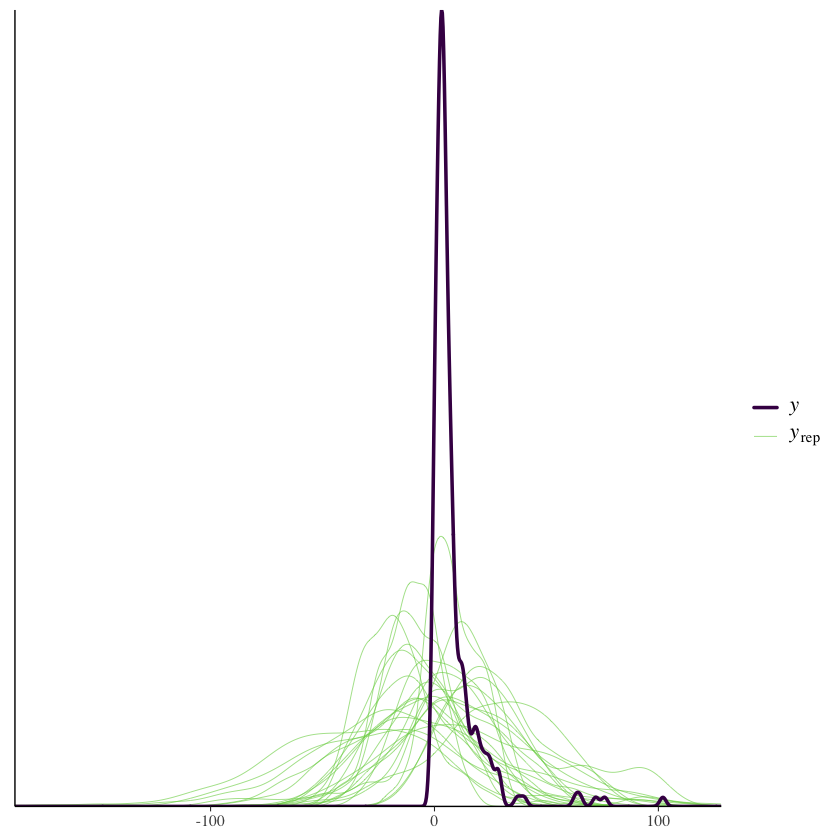

In [17]:
preds <- fit1$draws(variables = "ypred", format = "draws_matrix")[1:25, ]
ppc_dens_overlay(y =  as.integer(data$y), yrep = preds)

We can from this clearly observe that our model is misspecified, since the predictive distribution here includes __negative__ values. We will next discuss how our model can be improved.

## 2. A second model: Poisson GLM ##
Since our response variable clearly consists of integer valued count data, a more natural assumption is to instead assume a log-linear Poisson model where
\begin{align*}
y_i | \lambda &\sim Poisson(\lambda_i) \\
\alpha &\sim N(0,5) \tag{4} \\ 
\beta_{1:4} &\sim N(0,1)
\end{align*}
and the means $\lambda_i$ depends on the individual covariates $x_i$ through the __log link__ function
$$
\log(\lambda_i) =  \alpha + x_i^T\beta 
$$


## Excersice 2
Complete the file "poisson.stan" to define this new model by

$\qquad$ a) Complete the translation of the model (4) in the $\verb|transformed parameters|$ and $\verb|model|$ block

$\qquad$ b) modify the $\verb|generate quantities|$ block to generate samples from the posterior predictive distribution.

__Tip: If you get stuck you can find correctly defined models in the "models_ref" directory__

The model can similarly be loaded and sampled from using the following code snippet:

In [18]:
model2 <- cmdstan_model("models/poisson.stan")
#model2 <- cmdstan_model("models_ref/poisson.stan") # Uncomment this for true reference solution

fit2 <- model2$sample(
  data = data,
  parallel_chains = 4,
  refresh = 0,
  show_messages = FALSE,
  show_exceptions = FALSE,
  seed = 2025
)

To see if this model fits data better, we conduct a new posterior predictive check as follows,

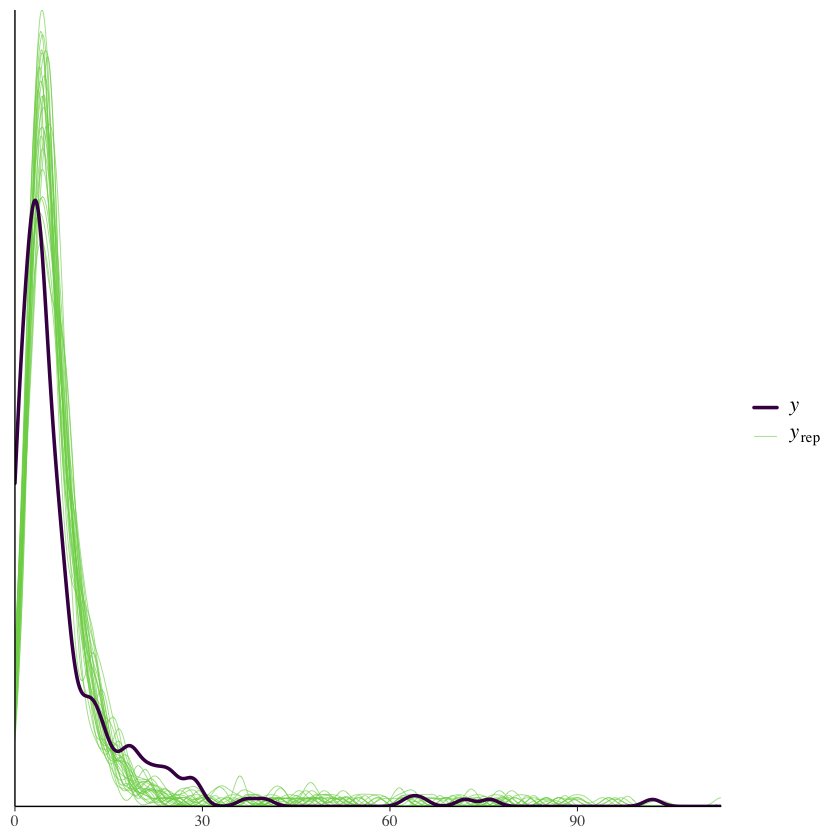

In [19]:
ppc_dens_overlay(y = data$y,
                 fit2$draws("ypred", format = "draws_matrix")[1:25,]) 

We see that switching to the Poisson GLM model indeed seems to yield a significantly better fit for our data!

### Model 3: Negative Binomial model
Although our Poisson model appears to fit our data much better, we see in the PPD plot that there still is some room for improvements to our model. A common extension of the Poisson model is to relax the assumption of equal mean and variance. More specifically, recall that for a Poisson distributed variable $X$ with intensity $\lambda$, it holds that

$$\mathbb{E}[X] = \operatorname{Var}[X] = \lambda, $$

which often is a too simplistic assumption in practice. A natural next step to relax this assumption is by adding a _dispersion_ parameter $\gamma$ to the model. In particular, if we assume that the mean $\lambda$ of the Poisson likelihood in turn follows a $Gamma(\gamma, \gamma)$ distribution, it can be shown that  the resulting _marginal_ likelihood is __Negative Binomial__ with mean $\lambda$ and variance $\lambda + \lambda^2\gamma$.

We see from this that the dispersion parameter $\gamma$ controls the degree of __overdispersion__, i.e., how much the variance deviates from the mean. Since the degree of overdispersion is not known, we can further extend our model to fit the $\gamma$ parameter by adding a prior on this. Using a truncated Cauchy distribution for the parameter. Using a truncated Cauchy distribution for this purpose we finally arrive at the following third model for our data:

\begin{align*}
y_i &\sim NegBin(\lambda_i, \gamma) \\
\log{\lambda_i} &= \alpha + x_i^T\beta \\
\alpha &\sim N(0,5) \\
\beta_{1:4} &\sim N(0,1) \\
\gamma &\sim Cauchy^+(0,5)
\end{align*}


The model is prepared in the model folder and is compiled and loaded similarly as before

In [20]:
cat(readLines("models/nb.stan"), sep = "\n")

data {
  int N;
  int T;
  int K;
  matrix[N*T, K] x;
  array[N*T] int y;
}

parameters {
  real alpha;
  vector[K] beta;
  real<lower=0> gamma;
}

transformed parameters {
  vector[N*T] lambda = exp(alpha + x * beta);
}

model {
  alpha ~ normal(0, 5);
  beta ~ std_normal();
  gamma ~ cauchy(0, 5);
  y ~ neg_binomial_2(lambda, gamma);
}

generated quantities {
  array[N*T] int ypred = neg_binomial_2_rng(lambda, gamma);
  array[N*T] real log_lik;

  // Evaluating log-likelihood for each data point and drawn sample 
  for (i in 1:N*T){
   log_lik[i] = neg_binomial_2_lpmf(y[i] | lambda[i], gamma);
  }
}


In [22]:
model3 <- cmdstan_model("models/nb.stan")

In [23]:
fit3 <- model3$sample(
  data = data,
  parallel_chains = 4,
  refresh = 0,
  show_messages = FALSE,
  show_exceptions = FALSE,
    seed =2025
)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


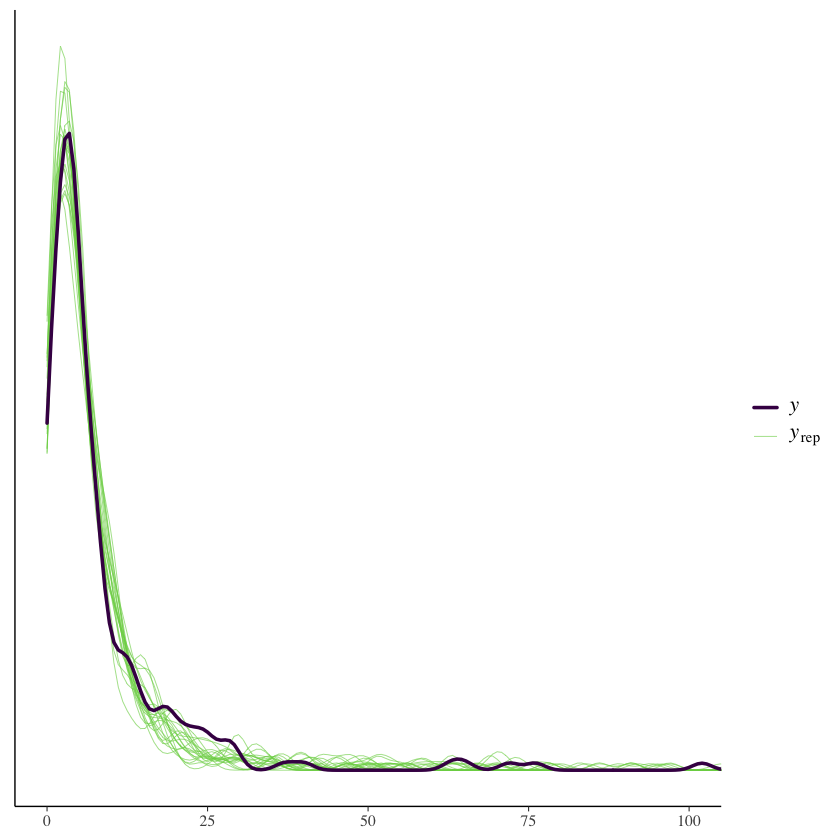

In [24]:
ppc_dens_overlay(y = data$y,
                 fit3$draws("ypred", format = "draws_matrix")[1:20,]) +
  coord_cartesian(xlim=c(0,100))

We see that a change to the Negative Binomial model appears to provide yet an improvement of the fit to our data. 
## Exersice 3:
Repeat the convergence diagnostics for the new model. 

In [ ]:
# TODO: write your code here

## Exersice 4:
Inspect the samples of the new fitted model. Investigate if/how the conclusions from the previous section are affected by changing to this new model.

In [31]:
# TODO: write your code here

## Exersice 5:

To quantify the uncertainty of the treatment effect parameter $\beta_1$, compute a 95% credible interval for $\beta_1$ by computing the empirical 2.5% and 97.5% quantiles of the $\beta_1$ samples. Which conclusions can be drawn from this? __Tip:__ Use R's $\verb|quantile|$ function. 

In [ ]:
# TODO: write your code here

We can also verify our hypothesis of overdispersion for our previous Poisson model we investigate the resulting $\gamma$ samples, again using a histogram

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


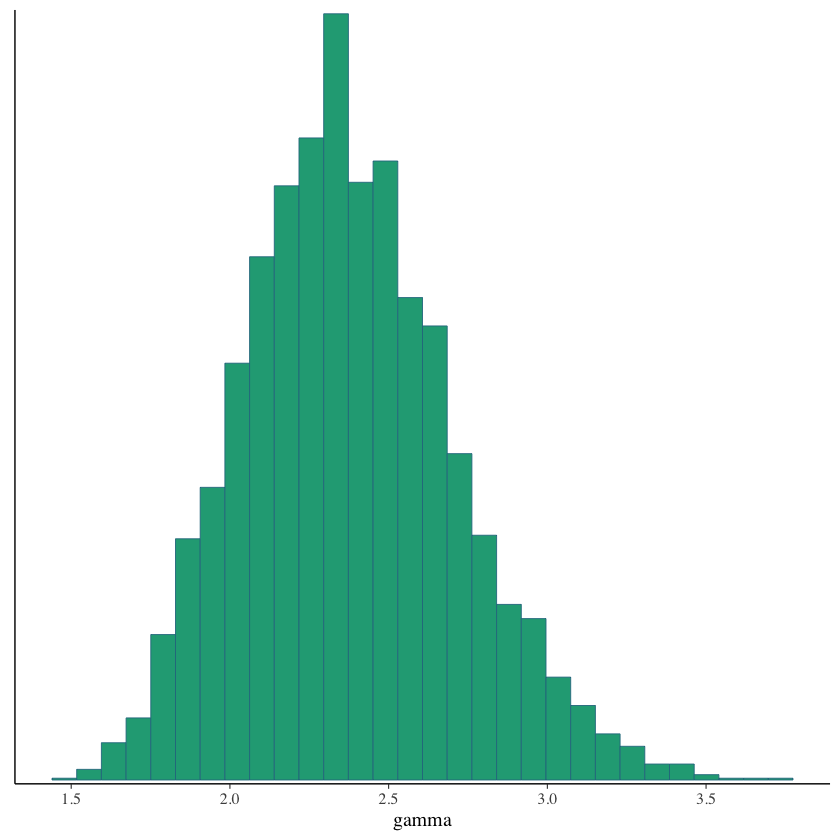

In [21]:
mcmc_hist(fit3$draws("gamma"))

From this we see clear indications of that overdispersion was present in our previous Poisson model and that chaning to the Negative Binomial model was justified.

### Model comparison

Using the posterior predictive distribution as a reference, we could inspect the progress when going from our baseline normal model to the final Negative Binomial model. In this last section we will evaluate and compare our three candidate models using the leave-one-out cross-validation (LOO-CV) using the $\verb|loo|$ package. Recall from the lecture slides that a useful metric for the fit of a Bayesian model is the expected log predictive density (ELPD) given by the following expression,
$$\mathbb{E}[\log(p_{post}(\hat{Y}|\theta))] = \int\log(p_{post}(\hat{y}|\theta))p(\hat{y})d\hat{y}, \tag{5}$$

where $p_{post}$ is the predictive posterior density and $p(\hat{y})$ is the true unknown data distribution. The function  $\verb|loo|$ from the  $\verb|loo|$-package estimates the ELPD using leave-one-out cross-validation together with Pareto smoothed importance sampling (PSIS-LOO-CV). To do this, the $\verb|loo|$ function takes as input evaluations of the log likelihood evaluated at the drawn samples, corresponding to the $\log(p_{post}(\hat{y}|\theta))$ component in the expression (5). 

In our prepared Stan code, the log-likelihood is generated in the $\verb|generated quantities|$ block and returned in the array "log_lik". Using these samples the ELPD can now be estimated for the Negative Binomial model using the $\verb|loo|$ function as follows,

In [25]:
log_lh_samples_model3 <- fit3$draws("log_lik") # Extracting the log-likelihood values 
model3_loo <- loo(log_lh_samples_model3)
model3_loo


Computed from 4000 by 236 log-likelihood matrix.

         Estimate   SE
elpd_loo   -664.2 19.1
p_loo         7.9  1.7
looic      1328.5 38.2
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume independent draws (r_eff=1).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.

The estimated ELPD can now be read out from the "elpd_loo" row in the generated table. A very important metric for the approximation to be valid is the Pareto-$k$ diagnostic, where $k < 0.7$ indicates that the estimates can be seen as trustworthy. 

## Exercice 6:

Do the corresponding modifications to the normal and Poisson model and then compute and compare the ELPD-LOO estimates between these models. Does the difference in ELPD match with our conclusions from the previous posterior predictive check plots? 

__Tip:__ the log-likelihood for the normal and poisson distribution is computed in Stan using the $\verb|normal_lpdf, poisson_lpdf|$ functions respectively. Again correct reference models can be found in the models_ref directory.


In [123]:
## TODO: Write your code here
